### Extraer dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.model_selection import cross_validate, RandomizedSearchCV, GridSearchCV, learning_curve, cross_val_predict
from scipy.stats import randint, uniform
import joblib
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve

In [2]:
import zipfile
from pathlib import Path

zip_path = Path("datasets/telco-customer-churn.zip")
extract_to = Path("datasets/extracted")

with zipfile.ZipFile(zip_path, "r") as zip_ref:
    filename = zip_ref.namelist()[0]
    extracted_file = extract_to / filename

    if not extracted_file.exists():
        zip_ref.extractall(extract_to)
        print("Unzipped to:", extract_to)
    else:
        print("CSV already extracted at: ", extracted_file)


CSV already extracted at:  datasets\extracted\WA_Fn-UseC_-Telco-Customer-Churn.csv


In [3]:
csv_path = "datasets/extracted/WA_Fn-UseC_-Telco-Customer-Churn.csv"

def load_telco_data(path):
    return pd.read_csv(path)

df = load_telco_data(csv_path)
    

## PASO 0: Revisión rápida de la estructura de datos

In [4]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### El dataset es un problema de clasificación, si un cliente ha decidido dejar el servicio de telecomunicacion

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


### Hay 7043 datos en el dataset, es una data pequeña. La data tiene 18 columnas tipo object(incluida la salida Churn), tres columnas tipo numérico y otra adicional tipo object, pero observamos que es numérica (TotalCharges). Revisaremos mejor estas columnas categóricas

## PASO 1: Crear Test set

In [6]:
strat_train_set, strat_test_set = train_test_split(df, test_size=0.2, stratify=df["Churn"], random_state=42)

In [7]:
print(f"Cantidad de data en training: {len(strat_train_set)}, Cantidad de data en test: {len(strat_test_set)}")

Cantidad de data en training: 5634, Cantidad de data en test: 1409


## PASO 2: Exploración de data inicial(EDA)

In [8]:
# Tipos de datos para cada feature
print('\n' + '='*50)
print("Tipos de datos y valores faltantes")
print(strat_train_set.info())

print('\n' + '='*50)
print("ESTADÍSTICA BÁSICA")
print(strat_train_set.describe())

# Revisar valores faltantes
print('\n' + '='*50)
print("TOTAL DE VALORES FALTANTES")
print(strat_train_set.isnull().sum())


Tipos de datos y valores faltantes
<class 'pandas.core.frame.DataFrame'>
Index: 5634 entries, 3738 to 5639
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5634 non-null   object 
 1   gender            5634 non-null   object 
 2   SeniorCitizen     5634 non-null   int64  
 3   Partner           5634 non-null   object 
 4   Dependents        5634 non-null   object 
 5   tenure            5634 non-null   int64  
 6   PhoneService      5634 non-null   object 
 7   MultipleLines     5634 non-null   object 
 8   InternetService   5634 non-null   object 
 9   OnlineSecurity    5634 non-null   object 
 10  OnlineBackup      5634 non-null   object 
 11  DeviceProtection  5634 non-null   object 
 12  TechSupport       5634 non-null   object 
 13  StreamingTV       5634 non-null   object 
 14  StreamingMovies   5634 non-null   object 
 15  Contract          5634 non-null   object 
 16  Paperles

### Existen 5634 datos en cada columna y se ve que no existen valores faltantes en este dataset. Sin embargo, TotalCharges se muestra como object, cuando tiene entradas numéricas; revisaremos mejor esta columna. Por otro lado, la columna SeniorCitizen tiene como valor maximo 1 y mínimo 0, esto quiere decir que ya está convertido a su contraparte codificada, indicando 0 cuando no es senior y 1 cuando sí lo es

In [9]:
# Mostraremos las filas donde TotalCharges no puede ser convertido a valor numerico
print(strat_train_set[pd.to_numeric(strat_train_set["TotalCharges"], errors="coerce").isna()])

      customerID  gender  SeniorCitizen Partner Dependents  tenure  \
6670  4075-WKNIU  Female              0     Yes        Yes       0   
4380  2520-SGTTA  Female              0     Yes        Yes       0   
3826  3213-VVOLG    Male              0     Yes        Yes       0   
488   4472-LVYGI  Female              0     Yes        Yes       0   
1082  4367-NUYAO    Male              0     Yes        Yes       0   
1340  1371-DWPAZ  Female              0     Yes        Yes       0   
6754  2775-SEFEE    Male              0      No        Yes       0   
3331  7644-OMVMY    Male              0     Yes        Yes       0   

     PhoneService     MultipleLines InternetService       OnlineSecurity  ...  \
6670          Yes               Yes             DSL                   No  ...   
4380          Yes                No              No  No internet service  ...   
3826          Yes               Yes              No  No internet service  ...   
488            No  No phone service          

### Podemos observar que hay 8 filas de TotalCharge que están vacías, pero no han sido formateadas como NaN. Buscaremos formatearlas como NaN para tener una mejor representación de los valores faltante

In [10]:
strat_train_set["TotalCharges"] = pd.to_numeric(strat_train_set["TotalCharges"], errors="coerce")
print(strat_train_set.isnull().sum())

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        8
Churn               0
dtype: int64


### Podemos ver que la columna TotalCharges ahora tiene 8 valores NaN, luego veremos como lidiar con estos valores

In [11]:
print(strat_train_set["TotalCharges"].dtype)

float64


In [12]:
# Revisar valores unicos en las columnas categóricas
print('\n' + '='*50)
print("REVISAR VALORES ÚNICOS PARA LOS FEATURES CATEGÓRICOS")

categorical_cols = strat_train_set.select_dtypes(include=['object']).columns

# No estamos interesados en columnas con más de 10 valores únicos
filtered_cols = [col for col in categorical_cols if strat_train_set[col].nunique() < 10]

for col in filtered_cols:
    print(f"\n{col}: {strat_train_set[col].unique()}")

# Revisar cuántos No y Yes hay en la columna de salida (Churn)
print(strat_train_set['Churn'].value_counts())


REVISAR VALORES ÚNICOS PARA LOS FEATURES CATEGÓRICOS

gender: ['Male' 'Female']

Partner: ['No' 'Yes']

Dependents: ['No' 'Yes']

PhoneService: ['No' 'Yes']

MultipleLines: ['No phone service' 'No' 'Yes']

InternetService: ['DSL' 'Fiber optic' 'No']

OnlineSecurity: ['No' 'Yes' 'No internet service']

OnlineBackup: ['No' 'Yes' 'No internet service']

DeviceProtection: ['Yes' 'No' 'No internet service']

TechSupport: ['No' 'Yes' 'No internet service']

StreamingTV: ['Yes' 'No' 'No internet service']

StreamingMovies: ['Yes' 'No' 'No internet service']

Contract: ['Month-to-month' 'Two year' 'One year']

PaperlessBilling: ['No' 'Yes']

PaymentMethod: ['Electronic check' 'Mailed check' 'Credit card (automatic)'
 'Bank transfer (automatic)']

Churn: ['No' 'Yes']
Churn
No     4139
Yes    1495
Name: count, dtype: int64


In [13]:
churn = strat_train_set.copy()

### Primero convertiremos Churn a valores numéricos, ya que actualmente están mapeados como categóricos

In [14]:
churn['ChurnNumeric'] = churn['Churn'].map({"No": 0, "Yes": 1})

In [15]:
print("CORRELATION ANALYSIS")
print('=' * 50)

print("Correlations with ChurnNumerics")
print(churn.corr(numeric_only=True)['ChurnNumeric'].sort_values(ascending=False))

CORRELATION ANALYSIS
Correlations with ChurnNumerics
ChurnNumeric      1.000000
MonthlyCharges    0.198040
SeniorCitizen     0.145599
TotalCharges     -0.194814
tenure           -0.345593
Name: ChurnNumeric, dtype: float64


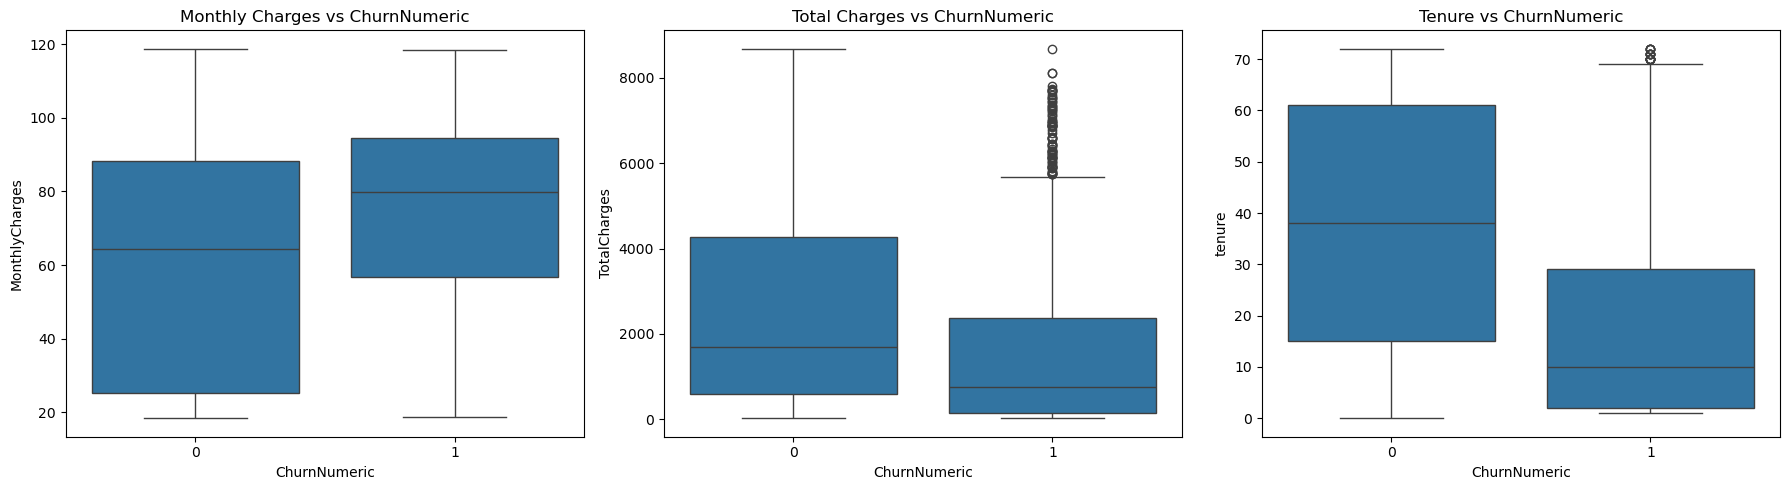

In [16]:
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.boxplot(x='ChurnNumeric', y='MonthlyCharges', data=churn, ax=axes[0])
axes[0].set_title("Monthly Charges vs ChurnNumeric")

sns.boxplot(x='ChurnNumeric', y='TotalCharges', data=churn, ax=axes[1])
axes[1].set_title("Total Charges vs ChurnNumeric")

sns.boxplot(x='ChurnNumeric', y='tenure', data=churn, ax=axes[2])
axes[2].set_title("Tenure vs ChurnNumeric")

plt.tight_layout()
plt.show()

### Este gráfico muestra que los cargos mensuales altos corresponden a clientes que se dieron de baja. Por otro lado, quienes se dieron de baja tienden a tener cargos totales más bajos y una menor permanencia, lo que significa que no permanecieron mucho tiempo. Plan caro = No lealtad. Sin embargo, hay algunos valores atípicos en TotalCharges y Tenure, lo que significa que en algunos casos los clientes que han pagado más y han permanecido más tiempo (altos totalcharges y tenure) se dieron de baja de todas formas

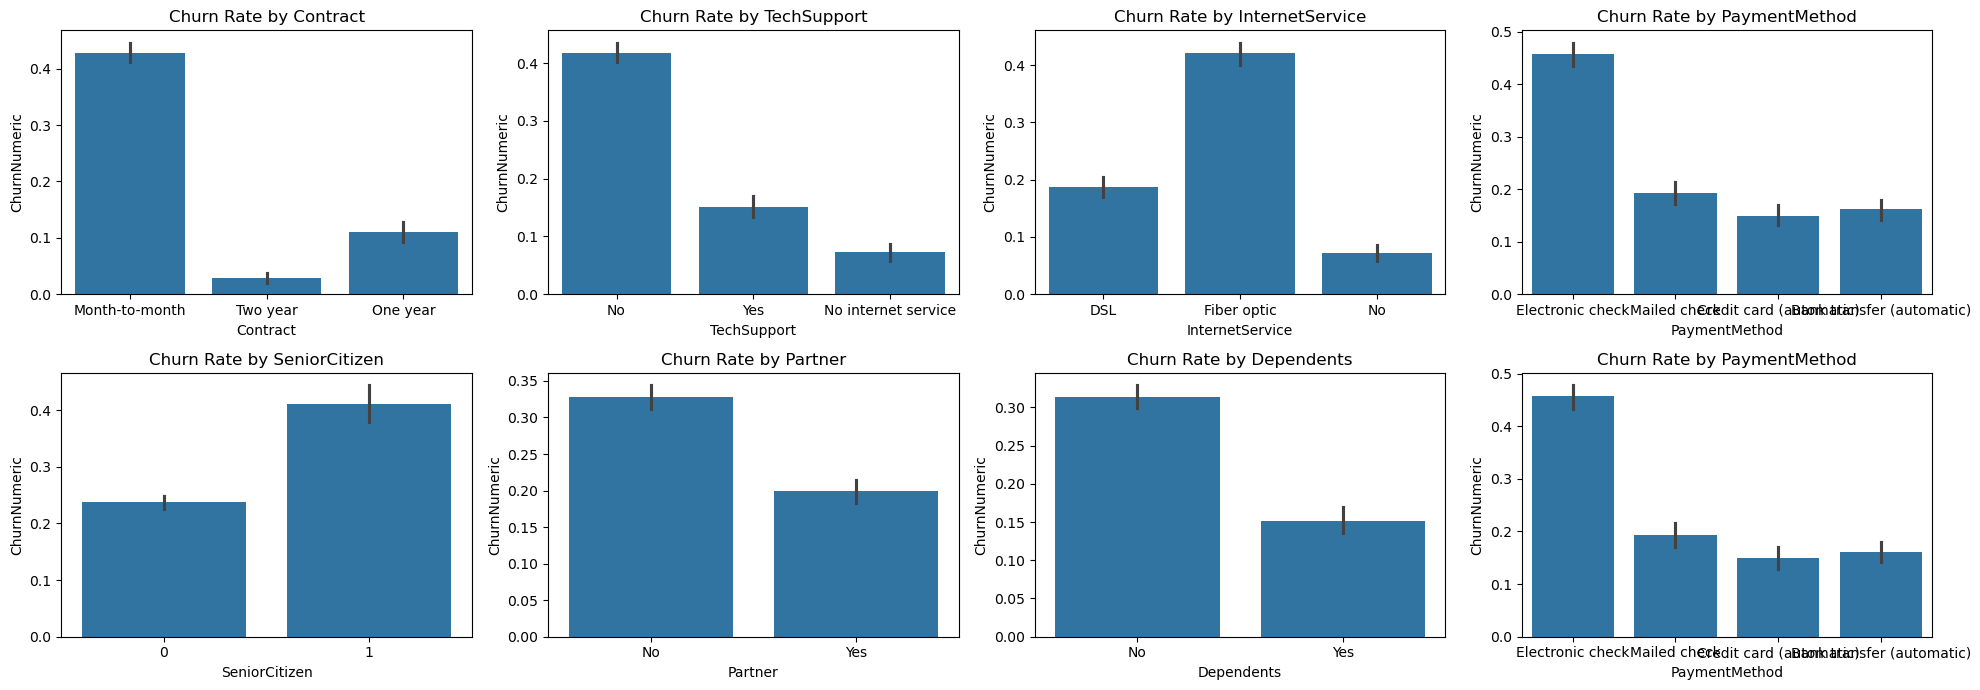

In [17]:
fig, axes = plt.subplots(2, 4, figsize=(20, 7))

# Contract	Month-to-month plans tend to churn more.
# TechSupport	No tech support = higher churn.
# InternetService	Fiber users often churn more than DSL.
# PaymentMethod	Electronic check users = higher risk.
# SeniorCitizen	Older customers sometimes churn less.
# Partner, Dependents	More stable customers.
# OnlineSecurity

sns.barplot(x="Contract", y="ChurnNumeric", data=churn, ax=axes[0][0])
axes[0][0].set_title("Churn Rate by Contract")

sns.barplot(x="TechSupport", y="ChurnNumeric", data=churn, ax=axes[0][1])
axes[0][1].set_title("Churn Rate by TechSupport")

sns.barplot(x="InternetService", y="ChurnNumeric", data=churn, ax=axes[0][2])
axes[0][2].set_title("Churn Rate by InternetService")

sns.barplot(x="PaymentMethod", y="ChurnNumeric", data=churn, ax=axes[0][3])
axes[0][3].set_title("Churn Rate by PaymentMethod")

sns.barplot(x="SeniorCitizen", y="ChurnNumeric", data=churn, ax=axes[1][0])
axes[1][0].set_title("Churn Rate by SeniorCitizen")

sns.barplot(x="Partner", y="ChurnNumeric", data=churn, ax=axes[1][1])
axes[1][1].set_title("Churn Rate by Partner")

sns.barplot(x="Dependents", y="ChurnNumeric", data=churn, ax=axes[1][2])
axes[1][2].set_title("Churn Rate by Dependents")

sns.barplot(x="PaymentMethod", y="ChurnNumeric", data=churn, ax=axes[1][3])
axes[1][3].set_title("Churn Rate by PaymentMethod")

plt.tight_layout()
plt.show()

### Vemos gráficas por cada valor categórico, indicando que los que pagan mes a mes, los que no tienen soporte técnico, los que tiene fibra óptica, etc, tienen mayores porcentajes de darse de baja.

### Experimentando con combinaciones de atributos

In [18]:
# +1 para evitar división por zero
churn["AvgMonthlySpend"] = churn["TotalCharges"] / (churn["tenure"] + 1)

# 
churn["TenureGroup"] = pd.qcut(churn["tenure"], q=4, labels=["Q1", "Q2", "Q3", "Q4"])

#
churn["IsNewCustomer"] = (churn["tenure"] < 3).astype(int)

#
churn["MonthlyChargeTier"] = pd.qcut(churn["MonthlyCharges"], q=4, labels=["Low", "Med", "High", "Very High"])

#
churn["LifetimeValueEstimate"] = churn["MonthlyCharges"] * churn["tenure"]

In [19]:
print("CORRELATION ANALYSIS")
print('=' * 50)

print("Correlations with ChurnNumerics")
print(churn.corr(numeric_only=True)['ChurnNumeric'].sort_values(ascending=False))

CORRELATION ANALYSIS
Correlations with ChurnNumerics
ChurnNumeric             1.000000
IsNewCustomer            0.260081
MonthlyCharges           0.198040
SeniorCitizen            0.145599
AvgMonthlySpend          0.078205
LifetimeValueEstimate   -0.193996
TotalCharges            -0.194814
tenure                  -0.345593
Name: ChurnNumeric, dtype: float64


### Visualizar las correlaciones de los nuevos atributos

In [20]:
churn.groupby("TenureGroup")["ChurnNumeric"].mean()
#churn.groupby("TenureGroup")["ChurnNumeric"].mean().plot(kind="bar")

C:\Users\Usuario\AppData\Local\Temp\ipykernel_14852\1305832025.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn.groupby("TenureGroup")["ChurnNumeric"].mean()


TenureGroup
Q1    0.496924
Q2    0.286855
Q3    0.186869
Q4    0.080966
Name: ChurnNumeric, dtype: float64

### Visualizar la proporción de personas que se desvincularon por cada TenureGroup

In [21]:
churn.groupby("MonthlyChargeTier")["ChurnNumeric"].mean()
#churn.groupby("MonthlyChargeTier")["ChurnNumeric"].mean().plot(kind="bar")

C:\Users\Usuario\AppData\Local\Temp\ipykernel_15656\3382395408.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn.groupby("MonthlyChargeTier")["ChurnNumeric"].mean()


MonthlyChargeTier
Low          0.109297
Med          0.249823
High         0.369844
Very High    0.332859
Name: ChurnNumeric, dtype: float64

### Visualizar la proporción de personas que se desvincularon por cada MonthlyChargeTier

### De esta sección podemos deducir que las personas con los más altos tenure usualmente no se desvinculaban (personas cuya acumulación de pagos ha sido mayor), mientras que personas que pagaron grandes cantidades mensualmente se desvincularon
### Nuevos clientes con riesgo a desvincularse, planes caros con riesgo a desvincularse 

## Paso 3: Limpieza de data(valores faltantes) y feature engineering

In [21]:
churn = strat_train_set.drop(["Churn", "customerID"], axis=1)
churn_labels = strat_train_set["Churn"].copy().map({"No": 0, "Yes": 1})

print(churn.head())

      gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
3738    Male              0      No         No      35           No   
3151    Male              0     Yes        Yes      15          Yes   
4860    Male              0     Yes        Yes      13           No   
3867  Female              0     Yes         No      26          Yes   
3810    Male              0     Yes        Yes       1          Yes   

         MultipleLines InternetService OnlineSecurity OnlineBackup  \
3738  No phone service             DSL             No           No   
3151                No     Fiber optic            Yes           No   
4860  No phone service             DSL            Yes          Yes   
3867                No             DSL             No          Yes   
3810                No             DSL             No           No   

     DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
3738              Yes          No         Yes             Yes  Month-to

In [22]:
churn_labels.head()

3738    0
3151    0
4860    0
3867    0
3810    0
Name: Churn, dtype: int64

In [23]:
from sklearn.base import BaseEstimator, TransformerMixin

class FeatureAdder(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        X["AvgMonthlySpend"] = X["TotalCharges"] / (X["tenure"] + 1)

        X["IsNewCustomer"] = (X["tenure"] < 3).astype(int)

        X["LifetimeValueEstimate"] = X["MonthlyCharges"] * X["tenure"]

        X["TenureGroup"] = pd.qcut(
            X["tenure"], q=4, labels=["Q1", "Q2", "Q3", "Q4"]
        )

        X["MonthlyChargeTier"] = pd.qcut(
            X["MonthlyCharges"], q=4, labels=["Low", "Med", "High", "Very High"]
        )

        return X

### Se crea la clase FeatureAdder para añadir features a los conjuntos de datos

In [24]:
tmp = FeatureAdder().fit_transform(churn)
print(tmp.head())

      gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
3738    Male              0      No         No      35           No   
3151    Male              0     Yes        Yes      15          Yes   
4860    Male              0     Yes        Yes      13           No   
3867  Female              0     Yes         No      26          Yes   
3810    Male              0     Yes        Yes       1          Yes   

         MultipleLines InternetService OnlineSecurity OnlineBackup  ...  \
3738  No phone service             DSL             No           No  ...   
3151                No     Fiber optic            Yes           No  ...   
4860  No phone service             DSL            Yes          Yes  ...   
3867                No             DSL             No          Yes  ...   
3810                No             DSL             No           No  ...   

            Contract PaperlessBilling            PaymentMethod MonthlyCharges  \
3738  Month-to-month               No    

### Se ha creado tmp como variable temporal para obtener los nombres de cada columna, ya sea original o nueva, agregada con FeatureAdder, esta variable es churn (strat_train_set) ya modificado con los nuevos features

In [25]:
num_attribs = tmp.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_attribs = tmp.select_dtypes(exclude=["int64", "float64"]).columns.tolist()
binary_num_attribs = [col for col in num_attribs if tmp[col].dropna().nunique() == 2]
num_attribs = [col for col in num_attribs if col not in binary_num_attribs]
#cat_attribs = cat_attribs + binary_num_attribs 

print(num_attribs, cat_attribs, binary_num_attribs)

['tenure', 'MonthlyCharges', 'TotalCharges', 'AvgMonthlySpend', 'LifetimeValueEstimate'] ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'TenureGroup', 'MonthlyChargeTier'] ['SeniorCitizen', 'IsNewCustomer']


### Se obtienen los nombres de todos los atributos de tmp para uso posterior. 
### Se separan las columnas categeróricas de las numéricas y luego se  crea la variable columnas binarias a partir de las columnas numéricas. Esto se hace debido a que las columnas binarias (0 y 1) no deben ser alteradas por el pipeline numérico.

In [26]:
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    #("feature_adder", FeatureAdder()),
    ("scaler", StandardScaler()),
])

binary_num_pipeline = "passthrough"

cat_pipeline = Pipeline([
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

full_pipeline = Pipeline([
    ("feature_adder", FeatureAdder()),
    ("preprocessor", ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("binary_num", binary_num_pipeline, binary_num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ]))
])

### Los pasos son los sgets: 
### 1. FeatureAdder, Clase creada previamente para los features personalizados, si se desea agregar más o borrar alguno, se debe hacer en esta clase.
### 2. Pipeline numérico (Los valores faltantes son llenados con el imputer usando la media-mejor opción que la mediana, usualmente es más estable a outliers, y luego se usa el StandardScaler para estandarizar) 
### 3. Pipeline binario (No se debe hacer nada con estas columnas)
### 4. Pipeline categórico (onehotencoder)

In [28]:
churn_prepared = full_pipeline.fit_transform(churn)

### Una vez obtenidos los nombres de las columnas, podemos proseguir con transformar a churn de nuevo

In [29]:
ohe = full_pipeline.named_steps["preprocessor"].named_transformers_["cat"].named_steps["onehot"]
cat_feature_names = ohe.get_feature_names_out(cat_attribs)

feature_names = num_attribs + binary_num_attribs + cat_feature_names.tolist()

churn_prepared_df = pd.DataFrame(churn_prepared, columns=feature_names, index=churn.index)
print(feature_names)

['tenure', 'MonthlyCharges', 'TotalCharges', 'AvgMonthlySpend', 'LifetimeValueEstimate', 'SeniorCitizen', 'IsNewCustomer', 'gender_Female', 'gender_Male', 'Partner_No', 'Partner_Yes', 'Dependents_No', 'Dependents_Yes', 'PhoneService_No', 'PhoneService_Yes', 'MultipleLines_No', 'MultipleLines_No phone service', 'MultipleLines_Yes', 'InternetService_DSL', 'InternetService_Fiber optic', 'InternetService_No', 'OnlineSecurity_No', 'OnlineSecurity_No internet service', 'OnlineSecurity_Yes', 'OnlineBackup_No', 'OnlineBackup_No internet service', 'OnlineBackup_Yes', 'DeviceProtection_No', 'DeviceProtection_No internet service', 'DeviceProtection_Yes', 'TechSupport_No', 'TechSupport_No internet service', 'TechSupport_Yes', 'StreamingTV_No', 'StreamingTV_No internet service', 'StreamingTV_Yes', 'StreamingMovies_No', 'StreamingMovies_No internet service', 'StreamingMovies_Yes', 'Contract_Month-to-month', 'Contract_One year', 'Contract_Two year', 'PaperlessBilling_No', 'PaperlessBilling_Yes', 'Pay

### named_steps["preprocessor"] nos devuelve el ColumnTransformer dentro de nuestro pipeline, .named_transformers_["cat"] devuelve el transformador categórico, y named_steps["onehot"] nos devuelve el objeto onehotencoder como tal
### con ohe.get_feature_names_out(cat_attribs) obtenemos el nombre de cada columna one hot encoded

In [30]:
churn_prepared_df = pd.DataFrame(churn_prepared, columns=feature_names, index=churn.index)

churn_prepared_df.head()

,tenure,MonthlyCharges,TotalCharges,AvgMonthlySpend,LifetimeValueEstimate,SeniorCitizen,IsNewCustomer,gender_Female,gender_Male,Partner_No,...,PaymentMethod_Electronic check,PaymentMethod_Mailed check,TenureGroup_Q1,TenureGroup_Q2,TenureGroup_Q3,TenureGroup_Q4,MonthlyChargeTier_High,MonthlyChargeTier_Low,MonthlyChargeTier_Med,MonthlyChargeTier_Very High
3738,0.102371,-0.521976,-0.263290,-0.393729,-0.253464,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3151,-0.711743,0.337478,-0.504815,0.415079,-0.514920,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4860,-0.793155,-0.809013,-0.751214,-0.560710,-0.778067,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3867,-0.263980,0.284384,-0.173700,0.369557,-0.170483,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3810,-1.281624,-0.676279,-0.990851,-1.212006,-0.989954,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Paso 4: Entrenamiento de modelo & Evaluación

In [31]:
X_train = churn_prepared_df
y_train = churn_labels

In [32]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=500, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": HistGradientBoostingClassifier(random_state=42)
}

In [33]:
scoring = ["accuracy", "precision", "recall", "f1", "roc_auc"]

results = {}

In [34]:
for name, model in models.items():
    cv_results = cross_validate(model, X_train, y_train, cv=5, scoring=scoring, return_train_score=False)
    results[name] = {metric: cv_results[f"test_{metric}"].mean() for metric in scoring}

results_df = pd.DataFrame(results).T
print(results_df)

                     accuracy  precision    recall        f1   roc_auc
Logistic Regression  0.804222   0.664169  0.532441  0.590728  0.848685
Random Forest        0.789134   0.632444  0.491639  0.552987  0.823829
Gradient Boosting    0.793573   0.634301  0.523746  0.573371  0.834811


## Paso 5: Fine-tuning el modelo

In [35]:
rf_param_dist = {
    "n_estimators": randint(100, 500),
    "max_depth": [None] + list(np.arange(5, 30, 5)),
    "max_features": ["sqrt", "log2", None],
    "min_samples_split": randint(2, 10),
    "min_samples_leaf": randint(1, 5)
}

rf = RandomForestClassifier(random_state=42)
rf_random_search = RandomizedSearchCV(
    rf, param_distributions=rf_param_dist,
    n_iter=50, cv=5, scoring="f1", verbose=2, n_jobs=-1, random_state=42
)

rf_random_search.fit(X_train, y_train)

print("Best RF params:", rf_random_search.best_params_)
print("Best RF F1:", rf_random_search.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best RF params: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 9, 'n_estimators': 161}
Best RF F1: 0.5747568633828894


In [37]:
# hgb_param_grid = {
#     "learning_rate": [0.01, 0.05, 0.1],
#     "max_iter": [200, 500, 1000],
#     "max_depth": [3, 5, None],
#     "max_leaf_nodes": [15, 31, 63],
#     "min_samples_leaf": [20, 50, 100],
#     "l2_regularization": [0.0, 0.1, 1.0]
# }

# hgb = HistGradientBoostingClassifier(random_state=42)
# hgb_grid_search = GridSearchCV(
#     hgb, param_grid=hgb_param_grid,
#     cv=5, scoring="f1", verbose=2, n_jobs=-1
# )

# hgb_grid_search.fit(X_train, y_train)

# print("Best GB params:", hgb_grid_search.best_params_)
# print("Best GB F1:", hgb_grid_search.best_score_)

In [36]:
def plot_learning_curve(estimator, X, y, title):
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y, cv=5, scoring="f1", n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
    )

    train_mean = train_scores.mean(axis=1)
    train_std = train_scores.std(axis=1)
    val_mean = val_scores.mean(axis=1)
    val_std = val_scores.std(axis=1)

    plt.figure(figsize=(8,6))
    plt.plot(train_sizes, train_mean, "o-", color="blue", label="Training score")
    plt.plot(train_sizes, val_mean, "o-", color="green", label="Validation score")

    plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.1, color="blue")
    plt.fill_between(train_sizes, val_mean-val_std, val_mean+val_std, alpha=0.1, color="green")

    plt.title(title)
    plt.xlabel("Training set size")
    plt.ylabel("F1 score")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()


### Picking best model

In [37]:
# # Guardando el mejor modelo obtenido en hgb
# os.makedirs("models", exist_ok=True)

# save model into models/
#joblib.dump(hgb_grid_search.best_estimator_, "models/best_hgb_model.pkl")

In [38]:
final_model = joblib.load("best_hgb_model.pkl")

In [39]:
cv_results = cross_validate(final_model, X_train, y_train, cv=5, scoring=scoring, return_train_score=False)

for metric in scoring:
    print(f"{metric}: {cv_results[f'test_{metric}'].mean():.4f}")

accuracy: 0.8064
precision: 0.6705
recall: 0.5338
f1: 0.5937
roc_auc: 0.8455


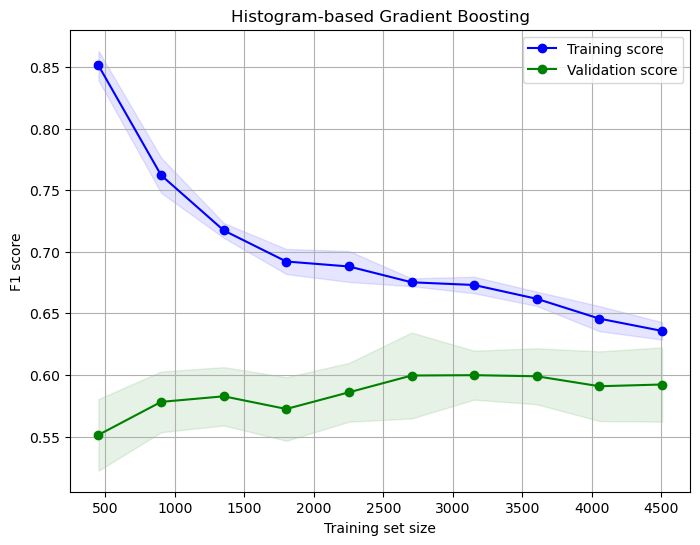

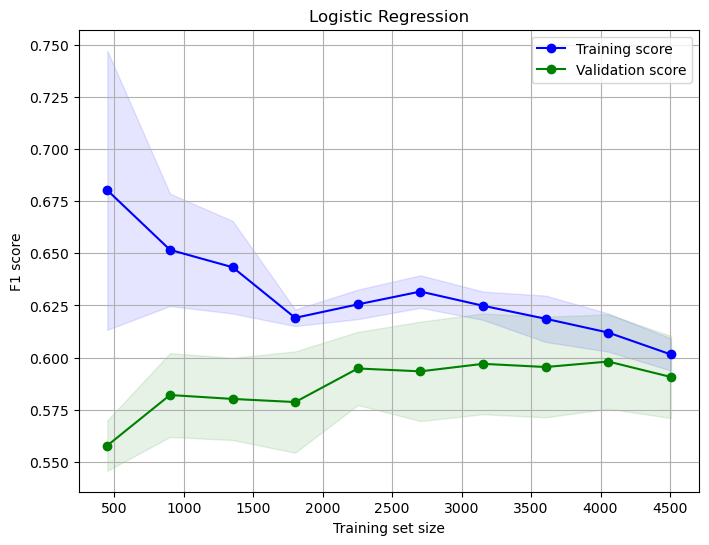

In [40]:
plot_learning_curve(final_model, X_train, y_train, "Histogram-based Gradient Boosting")
plot_learning_curve(models["Logistic Regression"], X_train, y_train, "Logistic Regression")

### Podemos observar que LR está haciendo underfitting (training y validation scores son bajos y convergen), mientras que HGB está haciendo overfitting (training score es mayor que validation score)

### Mirando las gráficas del learning_ curve, nos podemos dar cuenta que HGB is más poderoso que LR, aunque corre el riesgo de hacer overfitting. Esto se podría solucionar añadiendo regularización y obteniendo más data.

### Visualizaremos los parámetros del modelo final, cambiaremos algunos para prevenir overfitting

In [41]:
params = final_model.get_params()
print(params)

{'categorical_features': 'from_dtype', 'class_weight': None, 'early_stopping': 'auto', 'interaction_cst': None, 'l2_regularization': 0.0, 'learning_rate': 0.05, 'loss': 'log_loss', 'max_bins': 255, 'max_depth': 3, 'max_features': 1.0, 'max_iter': 200, 'max_leaf_nodes': 15, 'min_samples_leaf': 20, 'monotonic_cst': None, 'n_iter_no_change': 10, 'random_state': 42, 'scoring': 'loss', 'tol': 1e-07, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


In [42]:
regularized_final_model = HistGradientBoostingClassifier(
    **{**params,
       "learning_rate": 0.05,
       "max_depth": 5,
       "min_samples_leaf": 30,
       "l2_regularization": 1.0,
       "early_stopping": True,
    }
)

regularized_final_model.fit(X_train, y_train)

HistGradientBoostingClassifier(early_stopping=True, l2_regularization=1.0,
                               learning_rate=0.05, max_depth=5, max_iter=200,
                               max_leaf_nodes=15, min_samples_leaf=30,
                               random_state=42)

### Mantenemos params igual y modificamos los parámetros necesarios para prevenir overfitting

In [43]:
cv_results = cross_validate(regularized_final_model, X_train, y_train, cv=5, scoring=scoring, return_train_score=False)

for metric in scoring:
    print(f"{metric}: {cv_results[f'test_{metric}'].mean():.4f}")

accuracy: 0.7989
precision: 0.6531
recall: 0.5191
f1: 0.5777
roc_auc: 0.8448


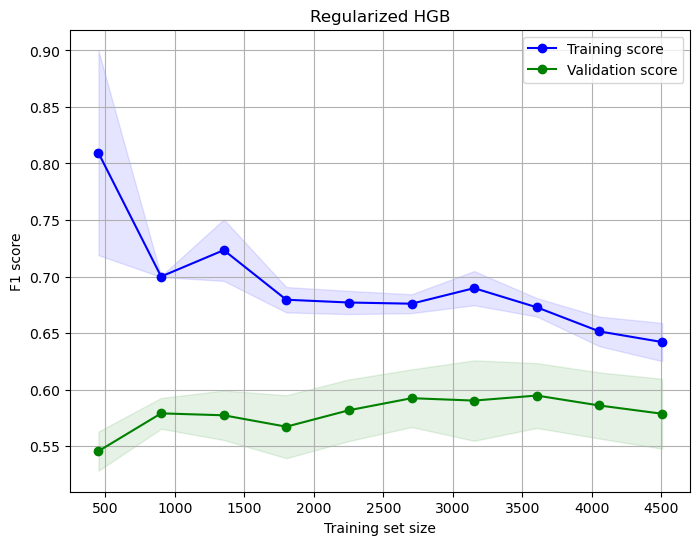

In [44]:
plot_learning_curve(regularized_final_model, X_train, y_train, "Regularized HGB")

### Además que las métricas de la version regularizada no son mejores que la versión no regularizada, es importante señalar que, gracias a la visualización del learning curve, la versión regularizada no reduce el overfitting, así que nos quedamos con final_model

## Paso 6: Feature importance

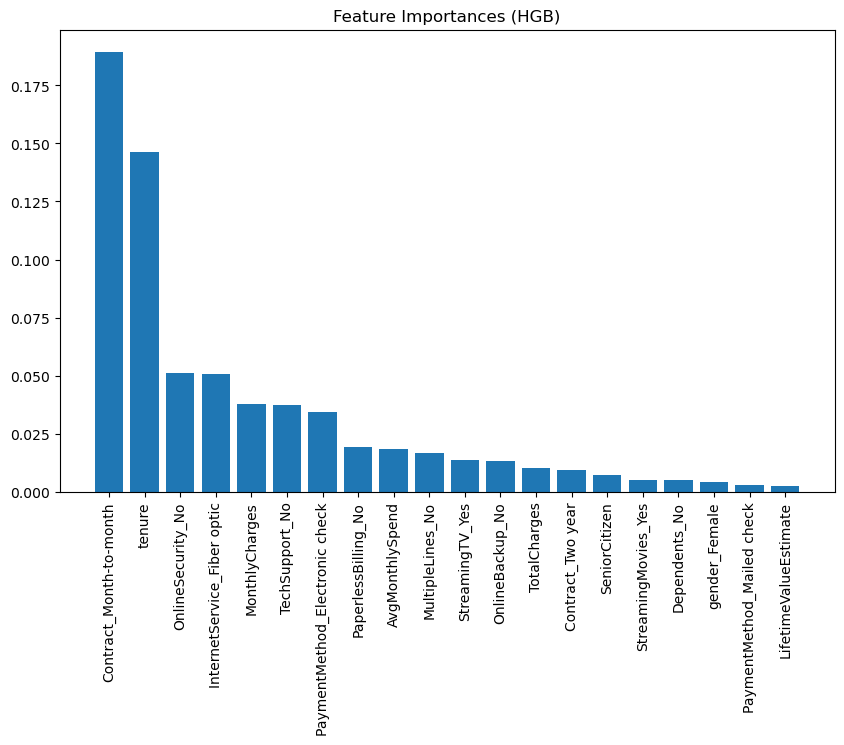

In [45]:
result = permutation_importance(
    final_model, X_train, y_train,
    n_repeats=10, random_state=42, scoring='f1'
)

importances = result.importances_mean
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
plt.title("Feature Importances (HGB)")
plt.bar(range(20), importances[indices][:20], align="center")
plt.xticks(range(20), np.array(feature_names)[indices][:20], rotation=90)
plt.show()

### Obtenemos los 20 features más importantes para el modelo
### Esto nos ayuda a saber a nivel de negocio cuáles son los features más importantes del modelo

## Paso 7: Final evaluation

In [46]:
X_test = strat_test_set.drop(["Churn", "customerID"], axis=1)
y_test = strat_test_set["Churn"].map({"No": 0, "Yes": 1})

In [47]:
# Recodar que habian valores vacíos en TotalCharges
print(X_test["TotalCharges"].dtype)

object


In [48]:
X_test["TotalCharges"] = pd.to_numeric(X_test["TotalCharges"], errors="coerce")

In [49]:
print(X_test["TotalCharges"].dtype)

float64


### Comprobamos que ya no hay valores vacíos que previenen que la columna TotaCharges se muestre como numérica

In [50]:
X_test_prepared = full_pipeline.transform(X_test)

y_pred = final_model.predict(X_test_prepared)
y_proba = final_model.predict_proba(X_test_prepared)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("Coonfusion Matrix:\n", confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1035
           1       0.67      0.52      0.59       374

    accuracy                           0.81      1409
   macro avg       0.76      0.71      0.73      1409
weighted avg       0.80      0.81      0.80      1409

ROC AUC: 0.8437675992663205
Coonfusion Matrix:
 [[940  95]
 [179 195]]


C:\Users\Usuario\miniconda3\envs\ml\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but HistGradientBoostingClassifier was fitted with feature names
  warnings.warn(
C:\Users\Usuario\miniconda3\envs\ml\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but HistGradientBoostingClassifier was fitted with feature names
  warnings.warn(


## Paso 8: Encontrando el mejor threshold (importa mas recall que precision)

In [51]:
y_scores_train = cross_val_predict(
    final_model, X_train, y_train,
    cv=5, method="predict_proba", n_jobs=-1
)[:, 1]

In [52]:
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores_train)

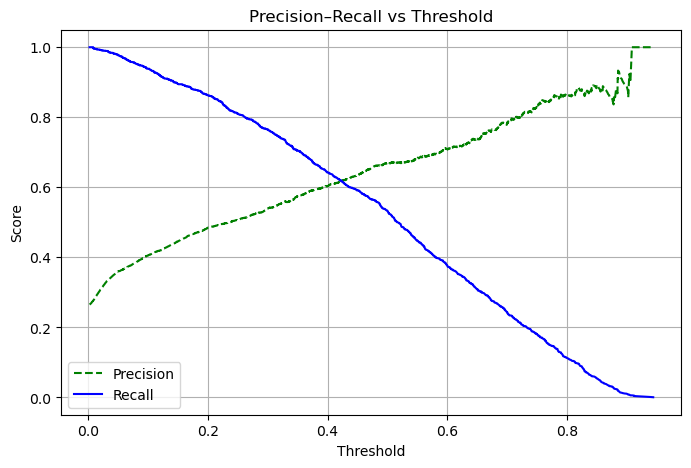

In [53]:
plt.figure(figsize=(8, 5))
plt.plot(thresholds, precisions[:-1], "g--", label="Precision")
plt.plot(thresholds, recalls[:-1], "b-", label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision–Recall vs Threshold")
plt.legend()
plt.grid(True)
plt.show()

### Podemos observar de la gráfica, que a un threshold de 0.5 (por defecto) el recall es de aproximadamente 0.5 mientras que la precisión 0.7. Por otro lado, para un threshold de 0.3 el recall es aprox 0.75 y la precisión es 0.55.
### Como mencionamos previamente, es más importante tener un recall alto que una precisón alta (nos debemos enfocar en Falsos negativos, esto es  los churners que han sido mal etiquetados como no chuners), entonces escogeremos el threshold 0.3, si bien bajamos en precisión, aumentamos el recall que es más importante en casos de churners

In [54]:
# Aplicando nuevo threshold
threshold = 0.3
y_pred_custom = (y_proba >= threshold).astype(int)

print(classification_report(y_test, y_pred_custom))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       0.90      0.76      0.83      1035
           1       0.54      0.78      0.64       374

    accuracy                           0.76      1409
   macro avg       0.72      0.77      0.73      1409
weighted avg       0.81      0.76      0.77      1409

ROC AUC: 0.8437675992663205


In [1]:
!pip freeze

anyio @ file:///C:/b/abs_5c8w79vk0u/croot/anyio_1745334672105/work
argon2-cffi @ file:///opt/conda/conda-bld/argon2-cffi_1645000214183/work
argon2-cffi-bindings @ file:///C:/b/abs_f11axiliot/croot/argon2-cffi-bindings_1736182463870/work
asttokens @ file:///C:/b/abs_9662ywy9fp/croot/asttokens_1743630464377/work
async-lru @ file:///C:/Users/dev-admin/perseverance-python-buildout/croot/async-lru_1729043741114/work
attrs @ file:///C:/b/abs_89hmquz5ga/croot/attrs_1734533130810/work
babel @ file:///C:/b/abs_ffzt1bmjth/croot/babel_1737454394148/work
beautifulsoup4 @ file:///C:/Users/dev-admin/perseverance-python-buildout/croot/beautifulsoup4-split_1729039630198/work
bleach @ file:///C:/Users/dev-admin/buildout/croot/bleach_1732924075369/work
Bottleneck @ file:///C:/b/abs_816hr2khp1/croot/bottleneck_1731058648110/work
Brotli @ file:///C:/b/abs_c415aux9ra/croot/brotli-split_1736182803933/work
brotlicffi @ file:///C:/b/abs_f4lixvzmxt/croot/brotlicffi_1736183286104/work
certifi @ file:///C:/b/abs